In [ ]:
import requests
import pandas as pd
from google.colab import drive
from googleapiclient.discovery import build
import time
import json
from google.colab import files
from googleapiclient.errors import HttpError
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic

# Packages for fine tuning BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.representation import PartOfSpeech

import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from tqdm import tqdm
from collections import defaultdict


#Importing packages for LDA
from gensim.corpora.dictionary import Dictionary  # You might need to install gensim first
from gensim.models.ldamulticore import LdaMulticore

import logging #This is to provide logging of information when running the LDA
from sklearn.metrics.pairwise import cosine_similarity

# Packages for fine tuning BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.representation import PartOfSpeech
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.metrics import silhouette_score

# Installing packages

In [ ]:
!pip install --upgrade --force-reinstall numpy gensim

In [ ]:
!pip install nltk

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

In [ ]:
!pip install hdbscan

In [ ]:
!pip install bertopic

# Importing data frames

In [ ]:
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
%cd # Directory location removed

In [ ]:
#df with translated and cleaned transcripts used for topic modeling
df_cleaned = pd.read_csv() # File location removed
df_cleaned.head()

In [ ]:
# Df with embeddings

embedding_df = pd.read_csv() # File location removed
embedding_df.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.069652,-0.115284,-0.018821,-0.145833,0.295005,-0.066359,-0.011431,-0.028900,0.079711,-0.027311,...,0.146651,-0.254471,0.134050,-0.215511,-0.067709,0.199671,0.078908,0.230968,-0.089152,0.138918
1,0.032234,-0.158599,-0.175157,0.148083,0.022659,-0.075285,0.293689,0.185292,0.074173,0.033734,...,-0.028924,-0.259362,0.232009,-0.000378,0.018417,0.184916,0.070820,0.116157,-0.155986,0.095746
2,-0.039689,0.191144,-0.339717,-0.094912,0.493698,0.030024,0.337703,0.215752,0.014599,0.119273,...,0.233327,0.026519,0.233623,0.182821,0.110865,0.119074,-0.281152,0.096418,-0.116570,-0.044387
3,-0.067146,0.086909,-0.182700,-0.090750,0.259385,-0.184687,0.185432,0.143752,0.162617,0.141343,...,-0.006580,-0.226544,0.143952,0.035424,-0.104191,0.023306,-0.165225,0.291774,-0.297519,-0.016801
4,0.129225,0.171033,-0.025118,0.008286,0.352300,-0.159025,0.217373,0.056504,0.110600,-0.027768,...,0.044196,-0.055489,0.134226,0.016897,0.205241,0.052132,0.097027,0.049950,-0.076142,0.113740


In [ ]:
# df with the collected comments

df_comments = pd.read_csv() # File location removed
df_comments.shape

(1075103, 7)

In [ ]:
# importing the df with data from the different news sources

df_1 = pd.read_csv() # File location removed
df_2 = pd.read_csv() # File location removed
df_3 = pd.read_csv() # File location removed
df_4 = pd.read_csv() # File location removed

In [ ]:
# Dropping unnecesary columns and merging all news sourcres

# preparing the dfs to merge
df_1 = df_1.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_2 = df_2.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2'])
df_3 = df_3.drop(columns=['Unnamed: 0'])
df_4 = df_4.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

# Rename transcript column in df4
df_4.rename(columns={"transcripts": "transcript"}, inplace=True)

# Merging
df_combined = pd.concat([df_1, df_2, df_3, df_4], axis=0, ignore_index=True)
df_combined.shape

(16366, 6)

In [ ]:
# Drop duplicated video ids

df_combined = df_combined.drop_duplicates(subset=['video_id'], keep='first')
df_combined.shape

(13524, 6)

In [ ]:
# removing videos from 2025
df_combined['video_date'] = pd.to_datetime(df_combined['video_date'])


df_combined = df_combined[df_combined['video_date'].dt.year != 2025]
df_combined.shape

(12531, 6)

In [ ]:
# Count transcripts with errors

error_count = df_combined['transcript'].str.startswith("Error: ").sum()
print("Number of error rows:", error_count)

Number of error rows: 225


In [ ]:
# Drop rows with errors

mask = ~df_combined['transcript'].fillna("").str.startswith("Error: ")
df_combined = df_combined[mask]

df_combined.shape

(12306, 6)

In [ ]:
# Chech for empty transcripts

nan_count = df_combined["transcript"].isna().sum()
empty_string_count = (df_combined["transcript"] == "").sum()
total_count = nan_count + empty_string_count

print(f"Number of NaN values: {nan_count}")
print(f"Number of empty strings: {empty_string_count}")
print(f"Total count of NaN and empty strings: {total_count}")

Number of NaN values: 51
Number of empty strings: 0
Total count of NaN and empty strings: 51


In [ ]:
# Drop NaN transcripts

df_combined = df_combined.dropna(subset=['transcript'])
df_combined.shape

(12255, 6)

# Exploratory analysis reports

In [ ]:
# Adding channel names
channel_mapping = {
    'UCpSJ5fGhmAME9Kx2D3ZvN3Q': 'Latina Noticias',
    'UCPhm2I2wk4vqjENwhn3px8A': 'America Noticias',
    'UC-B7Xv56uNRDkj0vC3QW8Cg': 'La Republica',
    'UCYG5uXS3xdsoaXIxum1pAEw': 'ATV Noticias',
    'UCLtGUPjKLqa3zgdmhKCZONg': 'El Comercio',
    'UC5j8-2FT0ZMMBkmK72R4aeA': 'RPP Noticias'
    }
#calculating number of videos per channel
df_combined['channel'] = df_combined['channel'].map(channel_mapping)
df_combined['channel'].value_counts()

,count
channel,
Latina Noticias,4947
America Noticias,2833
ATV Noticias,2282
RPP Noticias,1298
La Republica,500
El Comercio,395


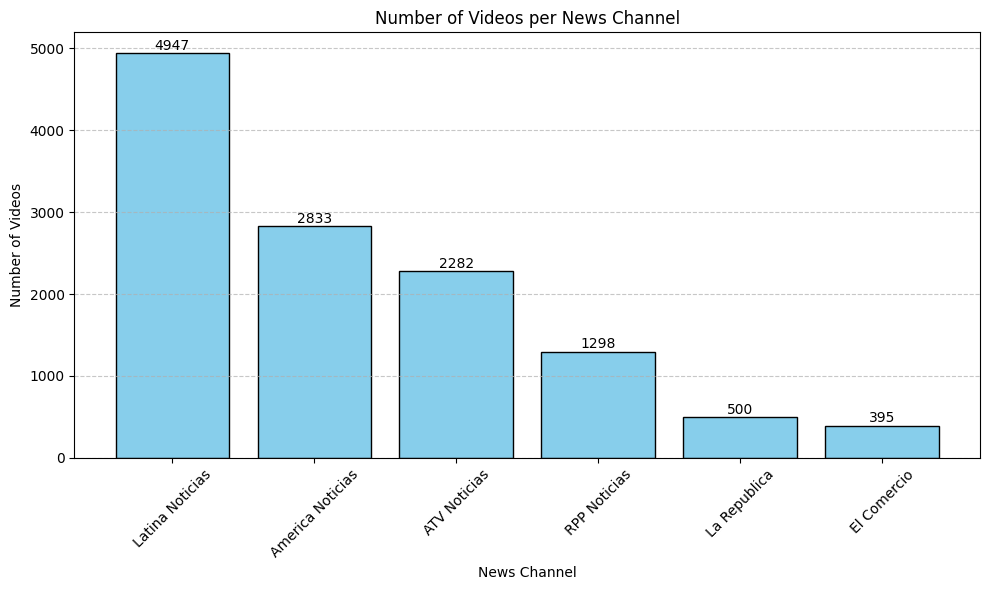

In [ ]:
channel_counts = df_combined['channel'].value_counts()

# Vizualizing
plt.figure(figsize=(10, 6))
bars = plt.bar(channel_counts.index, channel_counts.values, color='skyblue', edgecolor='black')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.title('Number of Videos per News Channel')
plt.xlabel('News Channel')
plt.ylabel('Number of Videos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Converting 'video_date' to a datetime format

df_combined['video_date'] = pd.to_datetime(df_combined['video_date'])

<Figure size 600x400 with 0 Axes>

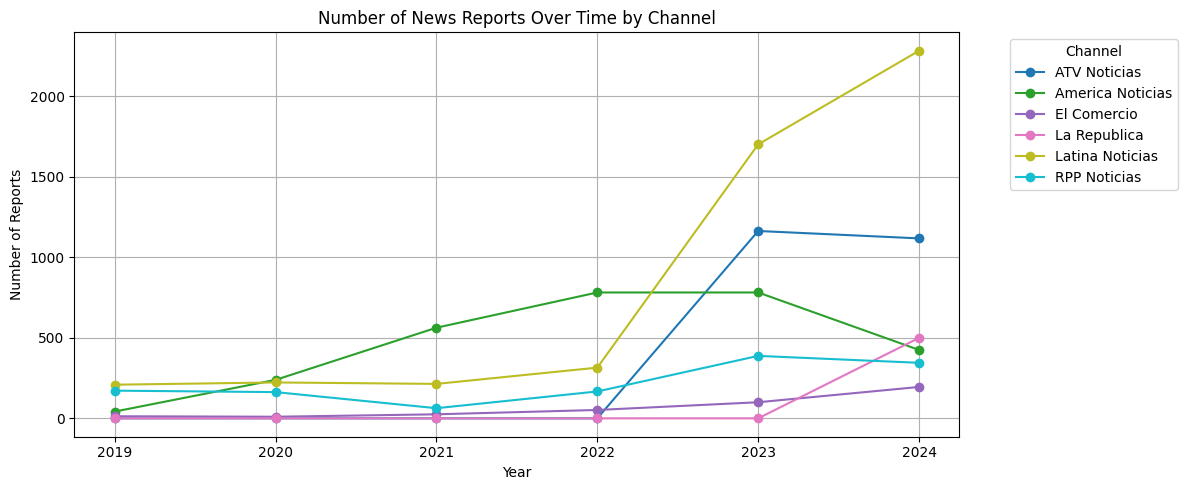

In [ ]:
# Year granularity

df_combined['year'] = df_combined['video_date'].dt.year


report_counts = df_combined.groupby(['year', 'channel']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = report_counts.pivot(index='year', columns='channel', values='count').fillna(0)

# Plot
plt.figure(figsize=(6, 4))
df_pivot.plot(kind='line', marker='o', figsize=(12, 5), cmap='tab10')

plt.title("Number of News Reports Over Time by Channel")
plt.xlabel("Year")
plt.ylabel("Number of Reports")
plt.legend(title="Channel", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

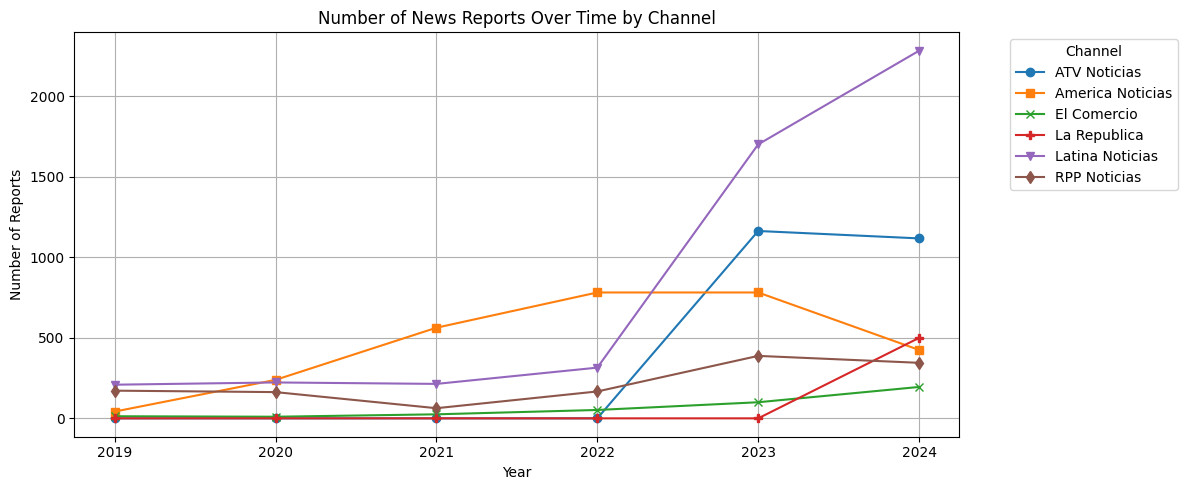

In [ ]:
# Unique markers

markers = ['o', 's', 'x', 'P', 'v', 'd']
colors = plt.get_cmap('tab10').colors

# Plot each line individually with a unique marker
plt.figure(figsize=(12, 5))
for i, column in enumerate(df_pivot.columns):
    plt.plot(df_pivot.index, df_pivot[column],
             label=column,
             marker=markers[i % len(markers)],
             color=colors[i % len(colors)])

plt.title("Number of News Reports Over Time by Channel")
plt.xlabel("Year")
plt.ylabel("Number of Reports")
plt.legend(title="Channel", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# average transcript lenght in words

df_combined['word_count'] = df_combined['transcript'].str.split().str.len()


average_word_count = df_combined['word_count'].mean()
print(f"Average transcript length (in words): {average_word_count:.2f}")

Average transcript length (in words): 1133.30


In [ ]:
#Average transcript lenght in characters

df_combined['char_count'] = df_combined['transcript'].str.len()

average_char_count = df_combined['char_count'].mean()
print(f"Average transcript length (in characters): {average_char_count:.2f}")

Average transcript length (in characters): 6432.76


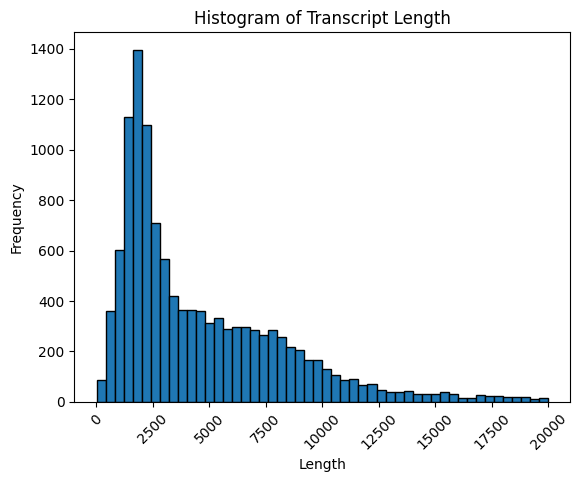

In [ ]:
# Checking transcripts length

df_combined['transcript_length'] = df_combined['transcript'].str.len()

df_filtered = df_combined[df_combined['transcript_length']<=20000]


plt.hist(df_filtered['transcript_length'], bins=50, edgecolor='black')
plt.xlabel('Length')
plt.ylabel('Frequency')
xticks = np.arange(0, max_len + 1000, 1000)
plt.xticks(rotation=45)  # Rotates x-axis labels
plt.title('Histogram of Transcript Length')
plt.show()

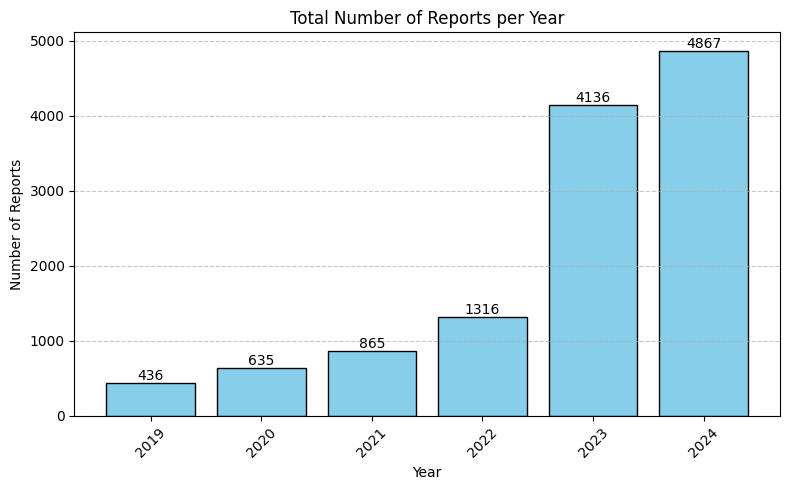

In [ ]:
# Group by year and count the number of videos

videos_per_year = df_combined['year'].value_counts().sort_index()

# Visualize
plt.figure(figsize=(8, 5))
bars = plt.bar(videos_per_year.index.astype(str), videos_per_year.values, color='skyblue', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(int(height)),
             ha='center', va='bottom', fontsize=10)

plt.title("Total Number of Reports per Year")
plt.xlabel("Year")
plt.ylabel("Number of Reports")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Comments data cleaning

In [ ]:
# Remove 2025
df_comments['published_at'] = pd.to_datetime(df_comments['published_at'])

df_comments = df_comments[df_comments['published_at'].dt.year != 2025]
df_comments.shape

(994141, 7)

In [ ]:
df_comments.head()

In [ ]:
num_unique_ids = df_comments['video_id'].nunique()
print(f"Number of unique video_ids: {num_unique_ids}")

Number of unique video_ids: 9379


In [ ]:
df_combined['channel'].unique()

array(['UC-B7Xv56uNRDkj0vC3QW8Cg', 'UCPhm2I2wk4vqjENwhn3px8A',
       'UCpSJ5fGhmAME9Kx2D3ZvN3Q', 'UC5j8-2FT0ZMMBkmK72R4aeA',
       'UCYG5uXS3xdsoaXIxum1pAEw', 'UCLtGUPjKLqa3zgdmhKCZONg'],
      dtype=object)

In [ ]:
# Removing comments made by the news souces

newssources = ['@LaRepublica','@americanoticiaspe', '@RPPNoticias',	'@latinanoticias', '@atvnoticias','@DiarioElComercio']
df_comments = df_comments[~df_comments['author'].isin(newssources)]
df_comments.shape

(993602, 7)

In [ ]:
# removing htm tags, URLs and extra spaces

def clean_text(comment):
    comment = re.sub(r'<.*?>', '', comment)
    comment = re.sub(r'http\S+', '', comment)
    comment = re.sub(r'\s+', ' ', comment).strip()
    return comment

df_comments['comment'] = df_comments['comment'].apply(clean_text)

In [ ]:
# only keep necesary columns

df_comments = df_comments.drop(['author', 'like_count', 'reply_to'], axis=1)

# Exploratory analysis comments

In [ ]:
df_comments.head(1)

In [ ]:
# average comment lenght in words
df_comments['word_count'] = df_comments['comment'].str.split().str.len()

average_word_count = df_comments['word_count'].mean()
print(f"Average transcript length (in words): {average_word_count:.2f}")

Average transcript length (in words): 19.69


In [ ]:
#Average comment lenght in characters
df_comments['char_count'] = df_comments['comment'].str.len()

average_char_count = df_comments['char_count'].mean()
print(f"Average transcript length (in characters): {average_char_count:.2f}")

Average transcript length (in characters): 113.28


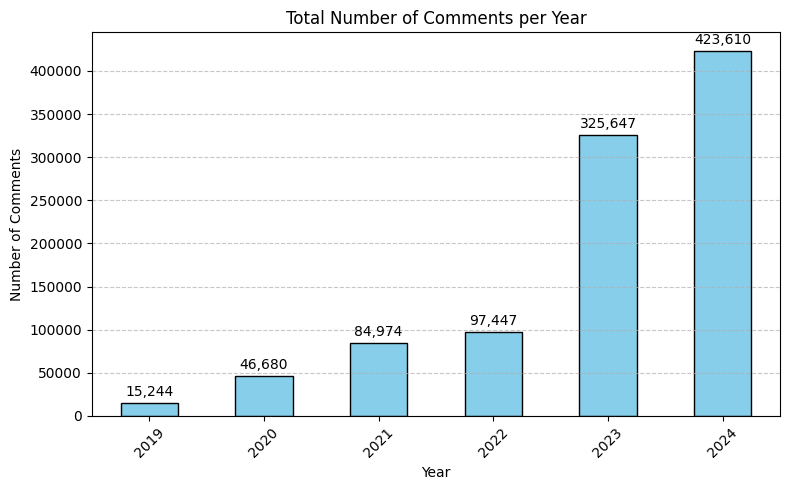

In [ ]:
# Extract year from published_at
df_comments['year'] = df_comments['published_at'].dt.year

videos_per_year = df_comments['year'].value_counts().sort_index()

# Visualize
plt.figure(figsize=(8, 5))
ax = videos_per_year.plot(kind='bar', color='skyblue', edgecolor='black')

for i, value in enumerate(videos_per_year):
    plt.text(i, value + max(videos_per_year)*0.01, f"{value:,}", ha='center', va='bottom', fontsize=10)

plt.title("Total Number of Comments per Year")
plt.xlabel("Year")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualizing BERT results

In [ ]:
#defining the model
# Initialize K-Means
kmeans_model = KMeans(n_clusters=11, init = 'k-means++', random_state = 42)

representation_model = PartOfSpeech("en_core_web_sm")

# Initializing UMAP
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine", random_state = 42)

kmeans_BERT = BERTopic(representation_model=representation_model
                       , umap_model=umap_model
                       #, umap_model = None
                       )

# Replace HDBSCAN with K-Means
kmeans_BERT.hdbscan_model = kmeans_model

In [ ]:
embeddings = embedding_df.to_numpy()

topics3, probs3 = kmeans_BERT.fit_transform(df_cleaned["filtered_transcript"].tolist(), embeddings)

In [ ]:
# Saving the topics and topic info
df_cleaned["topic"] = topics3
topic_info = kmeans_BERT.get_topic_info()
df_cleaned = df_cleaned.merge(topic_info[['Topic', 'Name']], left_on='topic', right_on='Topic', how='left')
df_cleaned.drop(columns=['Topic'], inplace=True)
df_cleaned.rename(columns={'Name': 'topic_keywords'}, inplace=True)

In [ ]:
#distance map from BERT
kmeans_BERT.visualize_topics()

In [ ]:
# Saving
distance_df = pd.read_excel() # File location removed
distance_df.head()

In [ ]:
# Create softmax probabilities
from scipy.special import softmax

# Drop the first NaN row
distance_df = distance_df.dropna(subset=["video_id"])

# Rename the column names
distance_df = distance_df.rename(columns={'Distance to topic centroid': 'Topic_0', 'Unnamed: 5': 'Topic_1', 'Unnamed: 6': 'Topic_2', 'Unnamed: 7': 'Topic_3', 'Unnamed: 8': 'Topic_4', 'Unnamed: 9': 'Topic_5',  'Unnamed: 10': 'Topic_6', 'Unnamed: 11': 'Topic_7', 'Unnamed: 12': 'Topic_8', 'Unnamed: 13': 'Topic_9', 'Unnamed: 14': 'Topic_10'})

# Select topic distance columns
topic_cols = [col for col in distance_df.columns if str(col).startswith("Topic_")]

# Convert distances to similarity
similarity_df = 1 - distance_df[topic_cols].astype(float)

# Apply softmax per row
prob_df = similarity_df.apply(softmax, axis=1)

# Rename columns
prob_df.columns = [f"Prob_{col}" for col in topic_cols]

In [ ]:
print(prob_df.head())

1    [0.34125506122834, 0.012540332848906849, 0.028...
2    [0.04691944727468032, 0.018934179795176455, 0....
3    [0.02634625922453483, 0.05200568814464649, 0.0...
4    [0.04398997872351872, 0.03560749508145057, 0.0...
5    [0.017653135712803598, 0.17470297188917833, 0....
dtype: object


In [ ]:
# Pribbility matrix
prob_matrix = pd.DataFrame(prob_df.apply(pd.Series))

# Rename the columns
prob_matrix.columns = [f"Prob_Topic_{i}" for i in prob_matrix.columns]

# Show a preview
prob_matrix.head()

In [ ]:
# coocurance matrix
# Create a binary topic-document matrix (1 if prob > threshold, else 0)
threshold = 0.2
binary_topic_matrix = (prob_matrix > threshold).astype(int)

# Compute co-occurrence by multiplying matrix with its transpose
cooccurrence_matrix = binary_topic_matrix.T @ binary_topic_matrix

# Remove self-cooccurrence if you don't want loops
np.fill_diagonal(cooccurrence_matrix.values, 0)

# Convert to DataFrame
cooccurrence_df = pd.DataFrame(cooccurrence_matrix,
                               index=cooccurrence_matrix.columns,
                               columns=cooccurrence_matrix.columns)

In [ ]:
cooccurrence_df

,Prob_Topic_0,Prob_Topic_1,Prob_Topic_2,Prob_Topic_3,Prob_Topic_4,Prob_Topic_5,Prob_Topic_6,Prob_Topic_7,Prob_Topic_8,Prob_Topic_9,Prob_Topic_10
Prob_Topic_0,0,0,0,1351,0,0,0,332,0,106,0
Prob_Topic_1,0,0,844,0,0,268,0,0,107,0,0
Prob_Topic_2,0,844,0,1,2,25,39,0,6,0,0
Prob_Topic_3,1351,0,1,0,0,0,0,299,0,0,0
Prob_Topic_4,0,0,2,0,0,46,238,112,14,0,0
Prob_Topic_5,0,268,25,0,46,0,19,0,0,0,0
Prob_Topic_6,0,0,39,0,238,19,0,0,0,0,0
Prob_Topic_7,332,0,0,299,112,0,0,0,0,66,0
Prob_Topic_8,0,107,6,0,14,0,0,0,0,0,0
Prob_Topic_9,106,0,0,0,0,0,0,66,0,0,0


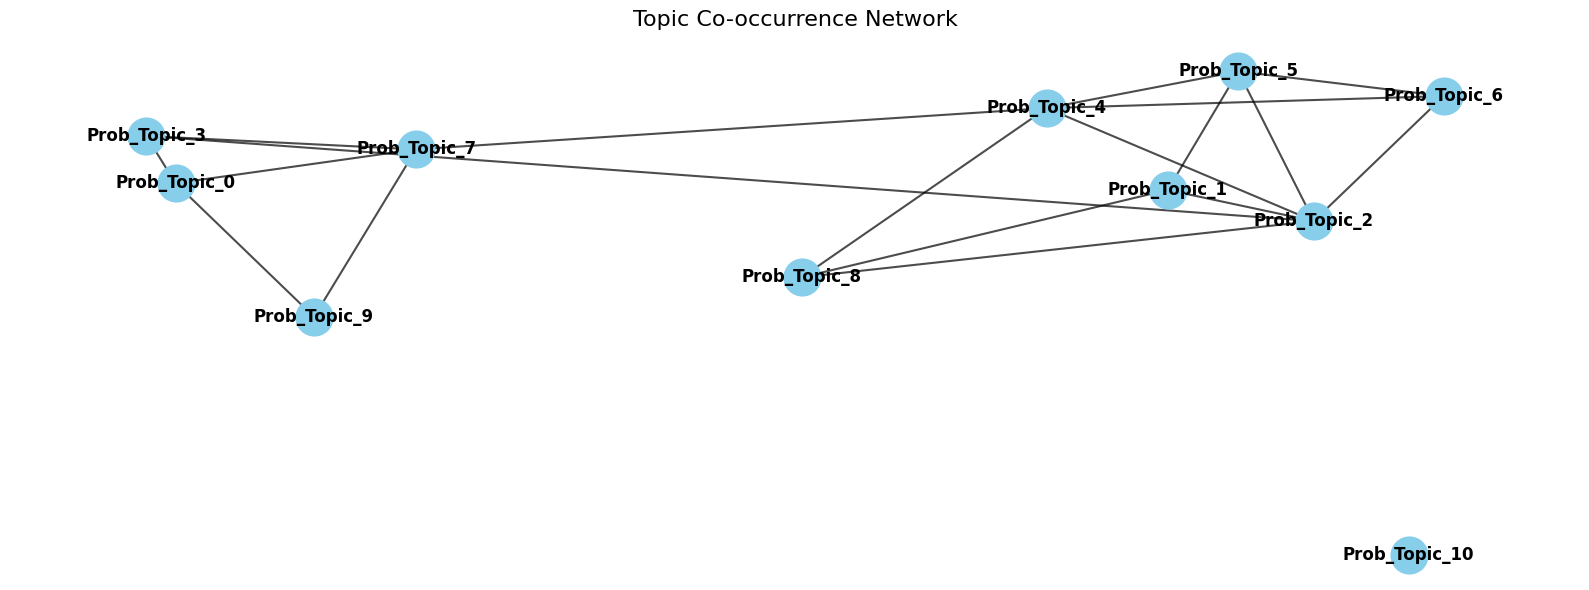

In [ ]:
import networkx as nx

# Create graph from co-occurrence matrix
G = nx.from_pandas_adjacency(cooccurrence_df)

# Draw the network
plt.figure(figsize=(16, 6))
pos = nx.spring_layout(G, k=3.5, seed=42)
edges = G.edges(data=True)

nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

plt.title("Topic Co-occurrence Network", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

#Vizualising topic development

praparing the df - adding time period and topic names

In [ ]:
#remove 2025
df_cleaned['video_date'] = pd.to_datetime(df_cleaned['video_date'])
df_cleaned = df_cleaned[df_cleaned['video_date'].dt.year != 2025]

In [ ]:
#adding the topic names
topic_names = {
    0: "0: Armed theft to businesses captured on security cameras",
    1: "1: Crime stories through interviews with victims' families",
    2: "2: Motorcycle crimes and witness involvement",
    3: "3: Neighborhood crime stories and self-organized measures",
    4: "4: Police intervention and gang capture cases",
    5: "5: Crimes linked to politics and public protests",
    6: "6: Extortion crimes and violent retaliation",
    7: "7: Robberies executed by organized crime groups",
    8: "8: Kidnapping crimes and police intervention",
    9: "9: Cybertheft through stolen devices",
    10: "10: Crimes involving dogs as victims, perpetrators or protectors",
}

df_cleaned['topic_name'] = df_cleaned['topic'].map(topic_names)

In [ ]:
# datetime format
df_cleaned['video_date'] = pd.to_datetime(df_cleaned['video_date'], errors='coerce')

df_cleaned['year'] = df_cleaned['video_date'].dt.year

# Define groups
def year_group(year):
    if 2019 <= year <= 2021:
        return '2019–2021'
    elif year == 2022:
        return '2022'
    elif year == 2023:
        return '2023'
    elif year == 2024:
        return '2024'
    else:
        return 'Other'  # In case there are years outside this range

# Apply the function
df_cleaned['year_group'] = df_cleaned['year'].apply(year_group)
df_cleaned['year_group'].unique()

array(['2019–2021', '2023', '2024', '2022'], dtype=object)

Visualizations:

In [ ]:
import plotly.express as px
import plotly.colors as pc

# Generate distinct colors
topic_ids = sorted(topics_over_time["Topic"].unique())
color_map = {topic: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] for i, topic in enumerate(topic_ids)}

# Update colors in the figure
for trace in fig.data:
    topic_number = int(trace.name.split("_")[0])  # Extract just the leading topic number
    if topic_number in color_map:
        trace.line.color = color_map[topic_number]

fig.show()

Occurance of articles about Venezuelans within each topic

In [ ]:
# Group by topic and calculate both percentage and count of Venezuelan-related videos
grouped = df_cleaned.groupby('topic_name')

percentage = grouped['bin_venezuelan'].mean() * 100

count_true = grouped['bin_venezuelan'].sum()

# Combine
topic_venezuelan_stats_df = pd.DataFrame({
    '%_reports_Venezuelan': percentage,
    'venezuelan_video_count': count_true
}).reset_index()

# Sort by percentage descending
topic_venezuelan_stats_df = topic_venezuelan_stats_df.sort_values(by='%_reports_Venezuelan', ascending=False)
topic_venezuelan_stats_df['%_reports_Venezuelan'] = topic_venezuelan_stats_df['%_reports_Venezuelan'].map(lambda x: f"{x:.1f}%")

topic_venezuelan_stats_df


,topic_name,%_reports_Venezuelan,venezuelan_video_count
4,3: Neighborhood crime stories and self-organiz...,25.8%,242
8,7: Robberies executed by organized crime groups,23.2%,157
10,9: Cybertheft through stolen devices,22.8%,103
5,4: Police intervention and gang capture cases,13.4%,127
3,2: Motorcycle crimes and witness involvement,11.3%,111
6,5: Crimes linked to politics and public protests,9.7%,77
7,6: Extortion crimes and violent retaliation,9.2%,71
2,1: Crime stories through interviews with victi...,7.0%,86
9,8: Kidnapping crimes and police intervention,6.3%,32
0,0: Armed theft to businesses captured on secur...,6.0%,138


Visualizing topic per year groups

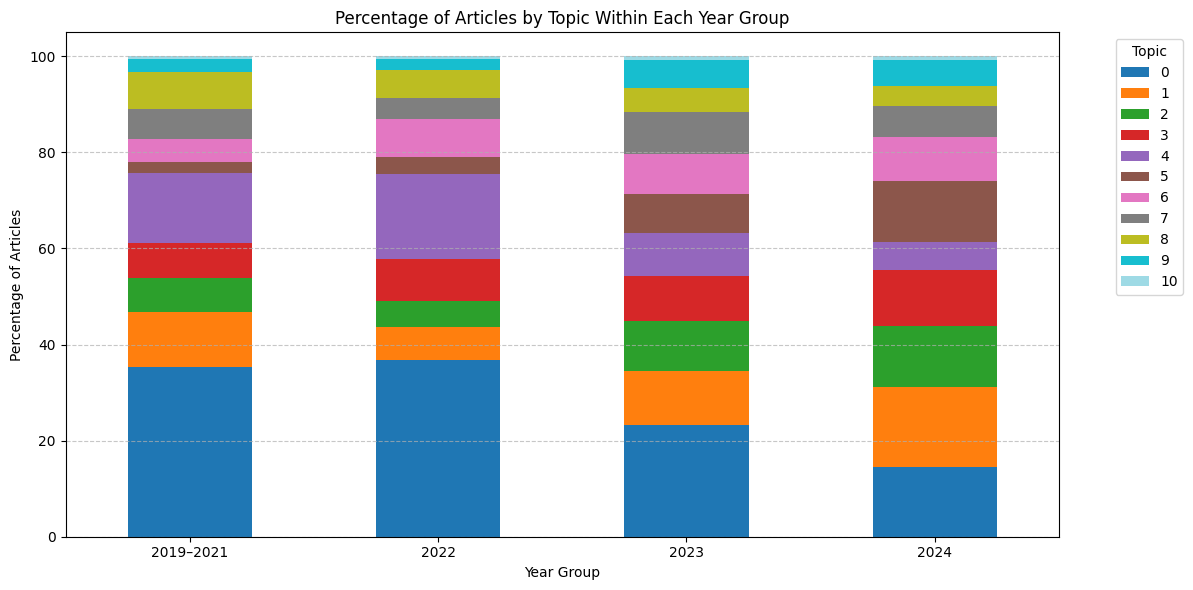

In [ ]:
# Normalize counts to percentages
topic_counts = df_cleaned.groupby(['year_group', 'topic']).size().unstack(fill_value=0)

topic_percent = topic_counts.div(topic_counts.sum(axis=1), axis=0) * 100

# Plot
topic_percent.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')


plt.title('Percentage of Articles by Topic Within Each Year Group')
plt.xlabel('Year Group')
plt.ylabel('Percentage of Articles')
plt.xticks(rotation=0)
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Visualizing Venezuelan group per year group

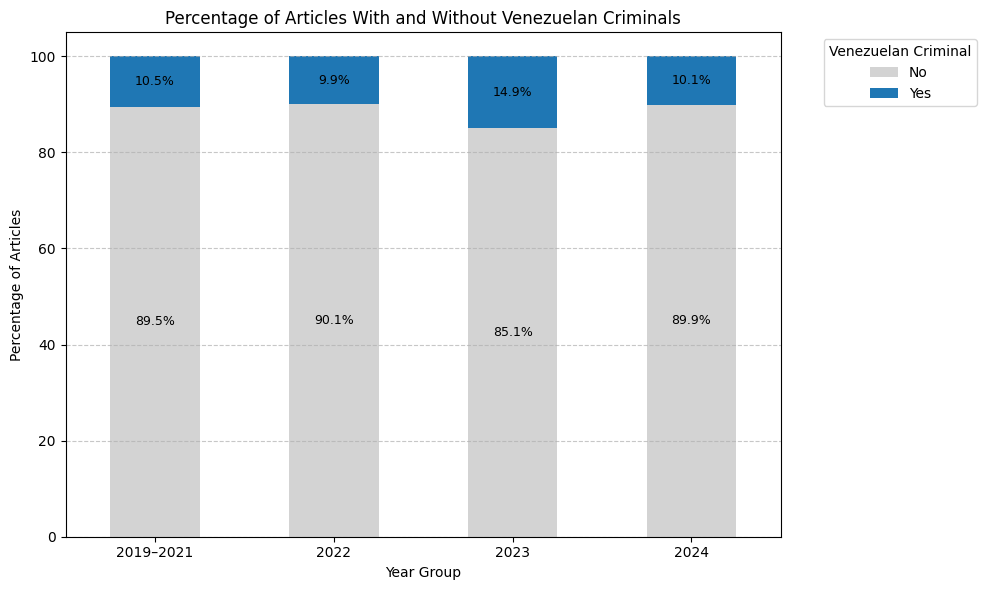

In [ ]:

# Group by year_group and binary flag
ven_counts = df_cleaned.groupby(['year_group', 'bin_venezuelan']).size().unstack(fill_value=0)

# Sort year groups
ordered_groups = ['2019–2021', '2022', '2023', '2024']
ven_counts = ven_counts.reindex(ordered_groups)

# percentage
ven_percent = ven_counts.div(ven_counts.sum(axis=1), axis=0) * 100

# Rename columns
ven_percent.columns = ['No', 'Yes'] if 0 in ven_percent.columns else ven_percent.columns

# Visualize
ax = ven_percent.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#d3d3d3', '#1f77b4'])

plt.title('Percentage of Articles With and Without Venezuelan Criminals')
plt.xlabel('Year Group')
plt.ylabel('Percentage of Articles')
plt.xticks(rotation=0)
plt.legend(title='Venezuelan Criminal', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels
for i, row in ven_percent.iterrows():
    bottom = 0
    for col in ven_percent.columns:
        value = row[col]
        if value > 0:
            ax.text(
                x=list(ven_percent.index).index(i),
                y=bottom + value / 2,
                s=f"{value:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )
            bottom += value

plt.show()

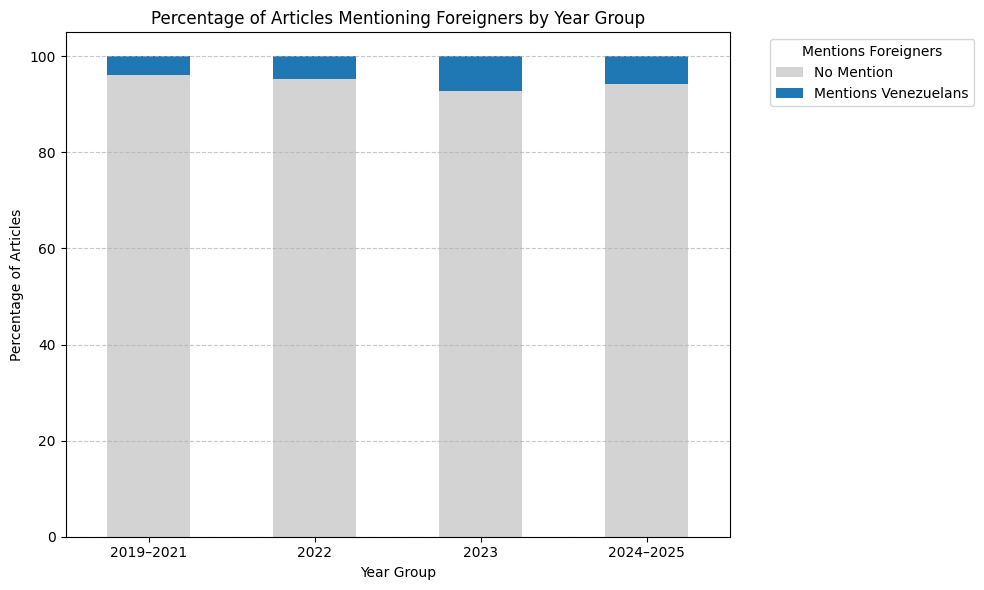

In [ ]:
# Group by year_group and binary flag
ven_counts = df_cleaned.groupby(['year_group', 'bin_foreigner']).size().unstack(fill_value=0)

# Sort year groups if needed
ordered_groups = ['2019–2021', '2022', '2023', '2024–2025']
ven_counts = ven_counts.reindex(ordered_groups)

# Normalize to get percentage
ven_percent = ven_counts.div(ven_counts.sum(axis=1), axis=0) * 100

# Rename columns for clarity (optional)
ven_percent.columns = ['No Mention', 'Mentions Venezuelans'] if 0 in ven_percent.columns else ven_percent.columns

# Plot
ven_percent.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#d3d3d3', '#1f77b4'])

plt.title('Percentage of Articles Mentioning Foreigners by Year Group')
plt.xlabel('Year Group')
plt.ylabel('Percentage of Articles')
plt.xticks(rotation=0)
plt.legend(title='Mentions Foreigners', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()